/home/m.ebrahimi/.conda/envs/m_base/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
/home/m.ebrahimi/.conda/envs/m_base/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
/home/m.ebrahimi/.conda/envs/m_base/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axi

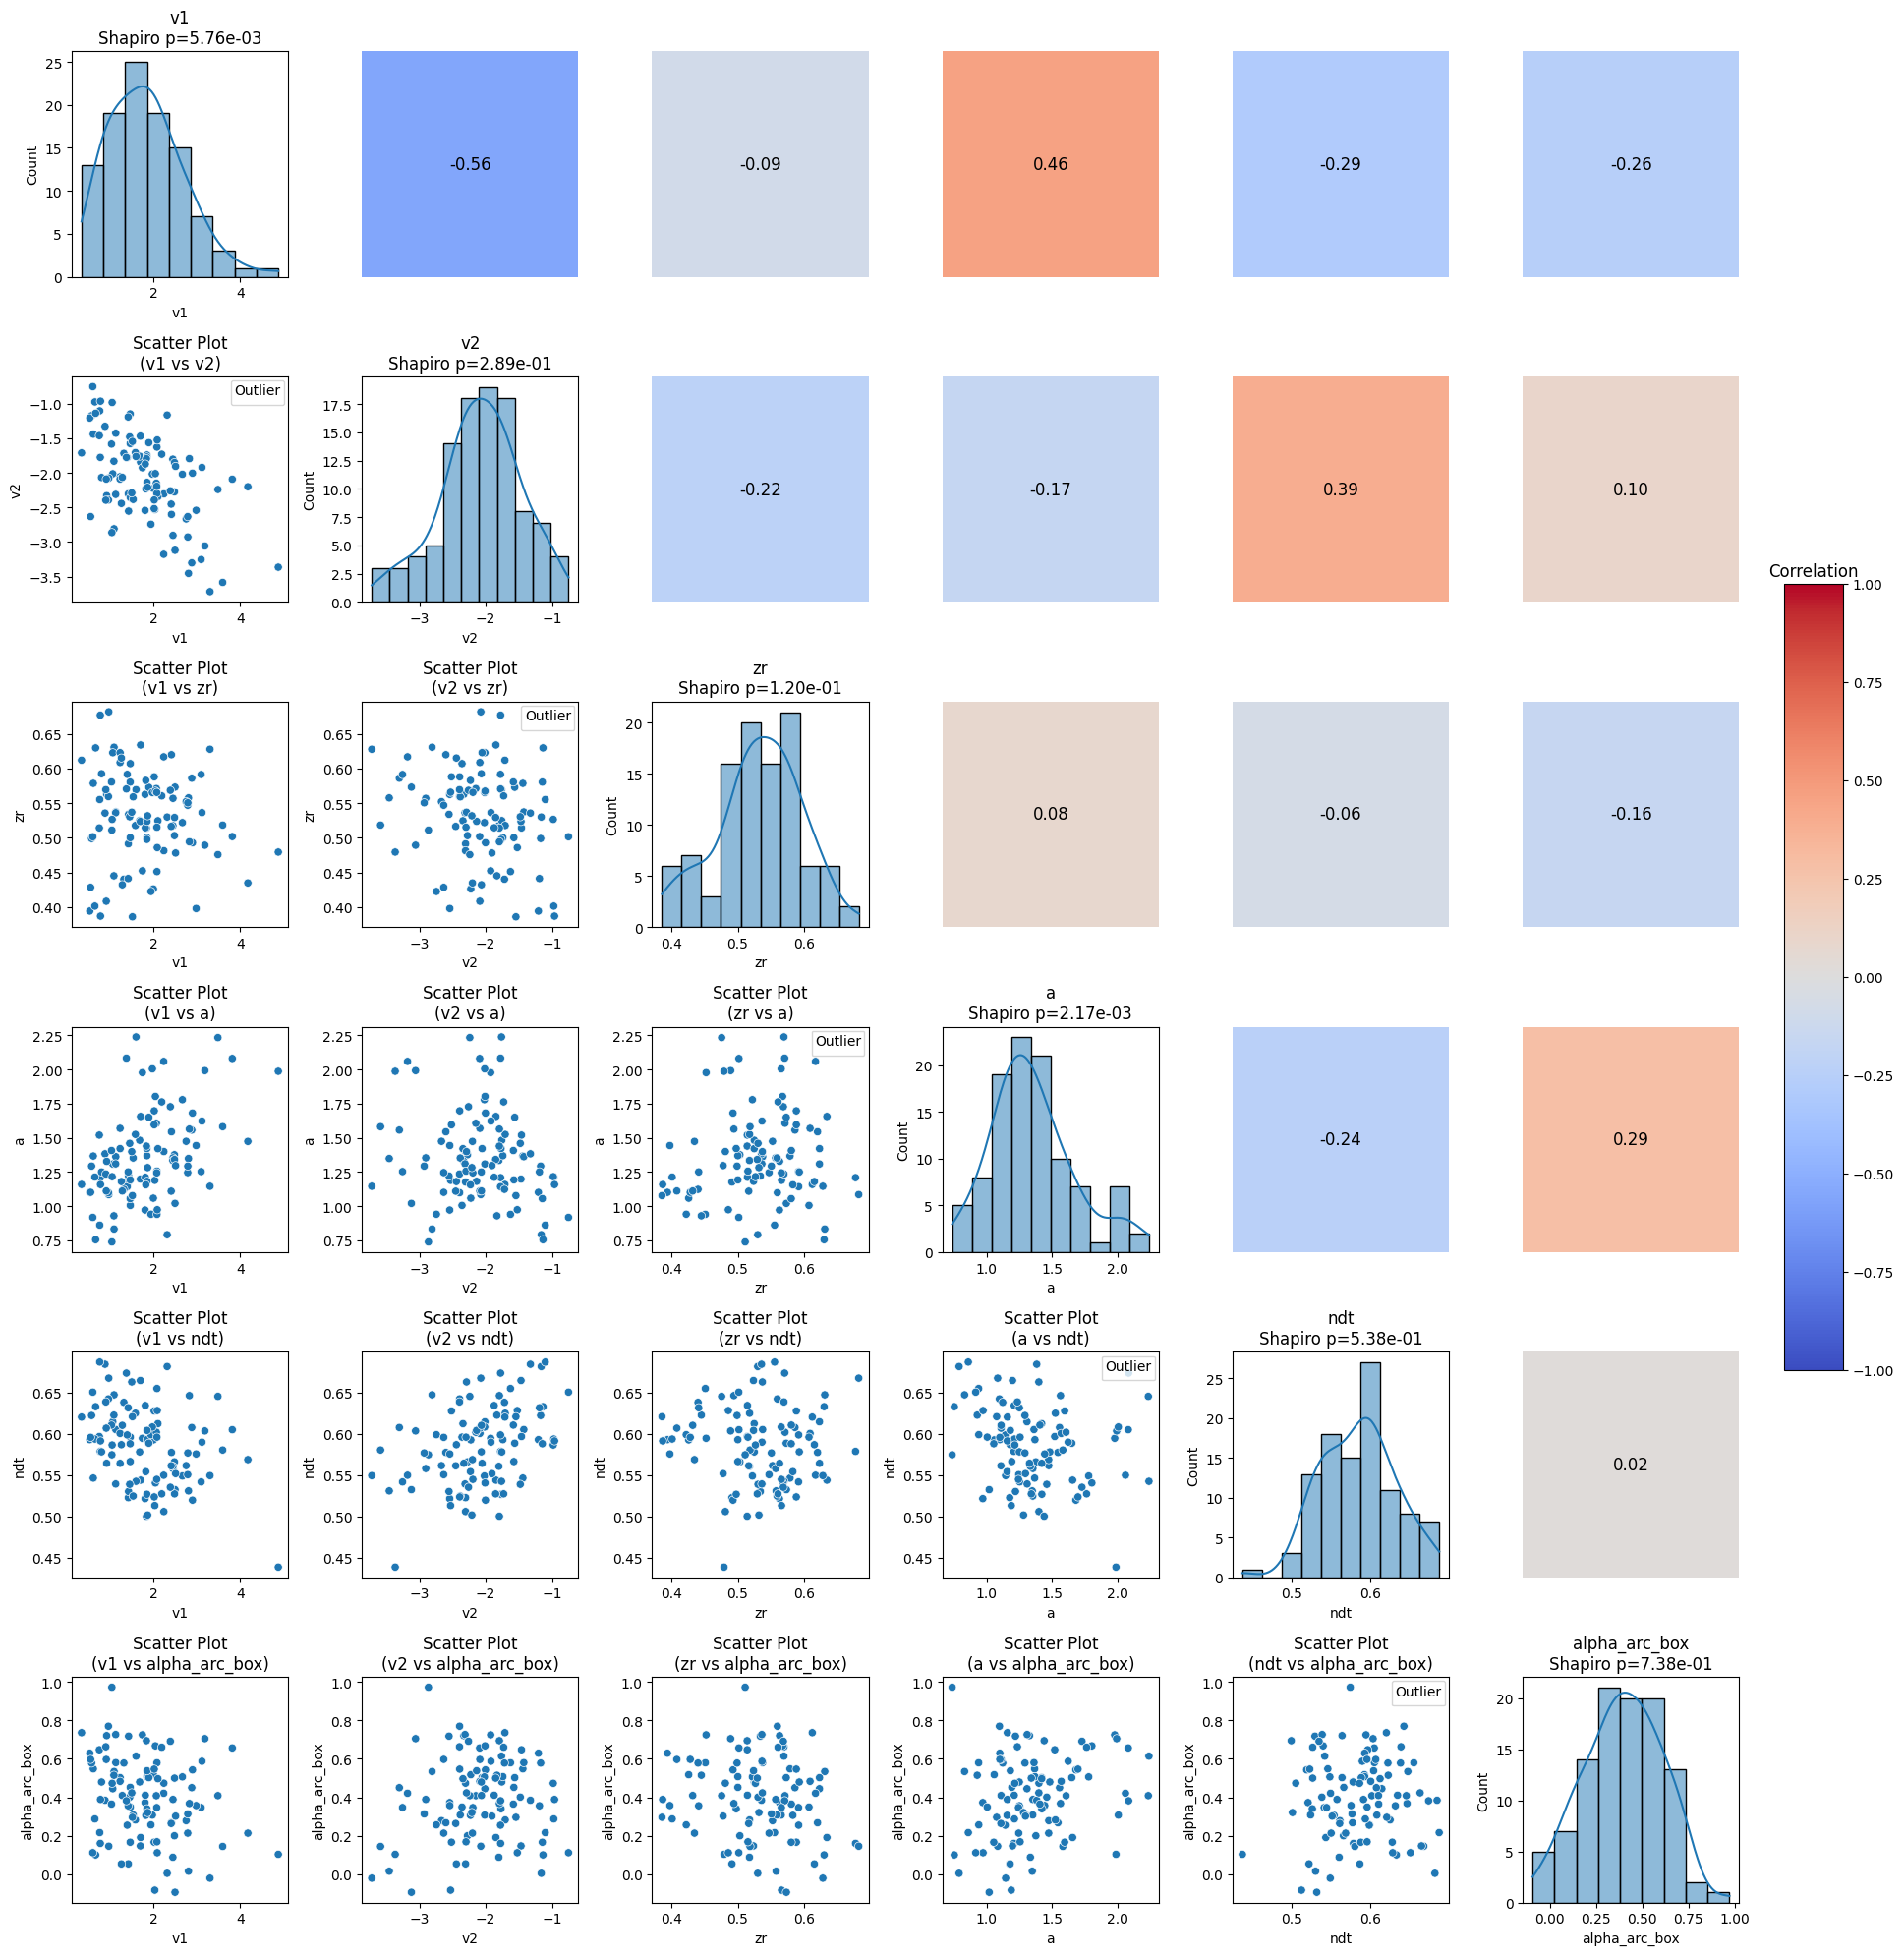

In [2]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
from itertools import combinations

# Function to calculate Mahalanobis distance
def safe_mahalanobis(x=None, data=None, cov=None):
    x_minus_mu = x - np.mean(data)
    if not cov:
        cov = np.cov(data.values.T)
    inv_covmat = np.linalg.inv(cov)
    left_term = np.dot(x_minus_mu, inv_covmat)
    mahal = np.dot(left_term, x_minus_mu.T)
    return mahal.diagonal()

# Load your data
data = pd.read_csv('rmt_session_1_data_transformed.csv')  # Replace with your file path

# Define your parameters
selected_params = ['v1_mean', 'v2_mean', 'zr_mean',
                   'a_mean', 'ndt_mean',# 'sndt_mean', 
                   #'alpha_mean',
                   'alpha_mean_boxcox_after_arcsin',
                   
                  # 'mean_log_rt', 'accuracy_percentage_boxcox_after_arcsin'
                  ]

# Renaming for simplicity
renamed_params = {
    'v1_mean': 'v1', 'v2_mean': 'v2', 'zr_mean': 'zr', 'a_mean': 'a', 
    'ndt_mean': 'ndt', #'sndt_mean': 'sndt', 'alpha_mean': 'alpha', 
    'alpha_mean_boxcox_after_arcsin': 'alpha_arc_box', 
   # 'mean_log_rt': 'mean_log_rt', 
   # 'accuracy_percentage_boxcox_after_arcsin': 'acc_arc_box'
}
data_renamed = data.rename(columns=renamed_params)

# Prepare for outlier detection and correlation
correlation_matrix = pd.DataFrame(index=selected_params, columns=selected_params)
p_value = 0.001

# Process each pair of parameters
for pair in combinations(selected_params, 2):
    pair_data = data[list(pair)]
    mahal_distances = safe_mahalanobis(x=pair_data, data=pair_data)
    threshold = stats.chi2.ppf((1 - p_value), df=2)
    outliers = mahal_distances > threshold
    correlation = pair_data[~outliers].corr().iloc[0, 1]
    correlation_matrix.loc[pair[0], pair[1]] = correlation
    correlation_matrix.loc[pair[1], pair[0]] = correlation

np.fill_diagonal(correlation_matrix.values, np.nan)
correlation_matrix_renamed = correlation_matrix.rename(columns=renamed_params, index=renamed_params)

# Shapiro-Wilk test
shapiro_results = {}
for param in selected_params:
    shapiro_test = stats.shapiro(data[param])
    shapiro_results[param] = shapiro_test[1]
shapiro_results_renamed = {renamed_params[key]: value for key, value in shapiro_results.items()}

# Create the visualization
# ... [rest of your code remains unchanged] ...

# Define the colormap for the heatmap
cmap = sns.color_palette("coolwarm", as_cmap=True)

# Create the visualization
fig, axn = plt.subplots(len(renamed_params), len(renamed_params), figsize=(20, 20))
cbar_ax = fig.add_axes([.91, .3, .03, .4])  # Adjust the position of the colorbar

for i, param_i in enumerate(renamed_params.values()):
    for j, param_j in enumerate(renamed_params.values()):
        ax = axn[i, j]
        if i == j:
            sns.histplot(data_renamed[param_i], kde=True, ax=ax)
            ax.set_title(f'{param_i}\nShapiro p={shapiro_results_renamed[param_i]:.2e}')
        elif i > j:
            sns.scatterplot(data=data_renamed, x=param_j, y=param_i, hue=outliers, legend=False, ax=ax)
            if i == j + 1:
                ax.legend(loc='upper right', title='Outlier', prop={'size': 6})
            ax.set_title(f'Scatter Plot\n({param_j} vs {param_i})')
        else:
            corr_value = correlation_matrix_renamed.iloc[i, j]
            color = cmap((corr_value + 1) / 2)
            ax.add_patch(plt.Rectangle((0, 0), 1, 1, color=color))
            ax.text(0.5, 0.5, f'{corr_value:.2f}', ha='center', va='center', fontsize=12)
            ax.axis('off')

# Create a colorbar
norm = plt.Normalize(vmin=-1, vmax=1)
fig.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), cax=cbar_ax)
cbar_ax.set_title('Correlation')

plt.tight_layout(rect=[0, 0, .9, 1])
plt.savefig('RMT_S1_correlation_matrix_Heatmap_plot.png')  # Saves the plot to a file
plt.show()
plt.close()




In [3]:
import pandas as pd

# Load the dataset
file_path = 'rmt_session_1_data_transformed.csv'
data = pd.read_csv(file_path)

# Display the first few rows of the dataframe
data.head()


,Unnamed: 0,Experiment,v1_mean,v2_mean,zr_mean,a_mean,ndt_mean,sndt_mean,alpha_mean,accuracy_percentage,...,RT_Cor_arr,ID,Task,Session,alpha_shifted,alpha_clipped,alpha_arcsin,alpha_mean_boxcox_after_arcsin,accuracy_arcsin,accuracy_percentage_boxcox_after_arcsin
0,171,001_class_pictures_part_1.dat,1.416757,-2.303725,0.491326,1.175885,0.522455,0.037854,1.751847,0.898477,...,1 0.672\n2 0.632\n3 1.171\n4 ...,1,RMT,Session 1,0.751847,0.751847,1.049333,0.054901,1.246516,0.280873
1,400,002_class_pictures_part_1.dat,1.086745,-2.807873,0.630802,0.832208,0.647012,0.062844,1.921944,0.845000,...,1 0.864\n2 0.631\n3 0.626\n4 ...,2,RMT,Session 1,0.921944,0.921944,1.287642,0.534390,1.166143,0.181703
2,355,003_class_pictures_part_1.dat,1.057104,-2.014052,0.622879,1.308224,0.614333,0.040702,1.904170,0.882653,...,1 1.008\n2 1.383\n3 0.907\n4 ...,3,RMT,Session 1,0.904170,0.904170,1.256062,0.444871,1.221157,0.248783
3,86,004_class_pictures_part_1.dat,2.481291,-2.274865,0.503201,1.375897,0.565844,0.038656,1.830303,0.959799,...,1 1.039\n2 1.408\n3 0.747\n4 ...,4,RMT,Session 1,0.830303,0.830303,1.146211,0.200689,1.368926,0.446206
4,401,005_class_pictures_part_1.dat,1.698414,-1.846684,0.634036,1.656270,0.543648,0.019052,1.826509,0.939394,...,1 1.046\n2 0.701\n3 0.682\n4 ...,5,RMT,Session 1,0.826509,0.826509,1.141180,0.191689,1.322056,0.380852


In [4]:
import numpy as np
import scipy.stats as stats

# Define the safe Mahalanobis function
def safe_mahalanobis(x=None, data=None, cov=None):
    x_minus_mu = x - np.mean(data)
    if not cov:
        cov = np.cov(data.values.T)
    inv_covmat = np.linalg.inv(cov)
    left_term = np.dot(x_minus_mu, inv_covmat)
    mahal = np.dot(left_term, x_minus_mu.T)
    return mahal.diagonal()

# Let's apply this to the first pair of parameters and check the result
pair = ['v1_mean', 'v2_mean']
data_pair = data[pair]

# Calculating Mahalanobis distance for the pair
mahal_distances = safe_mahalanobis(x=data_pair, data=data_pair)

# Determine the p-value threshold for outlier detection (p < 0.001)
p_value_threshold = 0.001

# Calculate the critical value for this p-value under the chi-squared distribution
critical_value = stats.chi2.ppf((1 - p_value_threshold), df=2)

# Identifying outliers
outliers = mahal_distances > critical_value

# Display the first few Mahalanobis distances and the outlier flags
mahal_distances[:5], outliers[:5]


/home/m.ebrahimi/.conda/envs/m_base/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


(array([0.78332699, 4.72168245, 0.99168123, 0.58208022, 0.15973181]),
 array([False, False, False, False, False]))

In [5]:
import numpy as np
import scipy.stats as stats

# Define the function for Mahalanobis distance
def safe_mahalanobis(x=None, data=None, cov=None):
    x_minus_mu = x - np.mean(data)
    if not cov:
        cov = np.cov(data.values.T)
    inv_covmat = np.linalg.inv(cov)
    left_term = np.dot(x_minus_mu, inv_covmat)
    mahal = np.dot(left_term, x_minus_mu.T)
    return mahal.diagonal()

# Select the first pair of parameters to demonstrate the process
params = ['v1_mean', 'v2_mean']
data_subset = data[params]

# Calculate the Mahalanobis distance for each observation
mahal_distances = safe_mahalanobis(x=data_subset, data=data_subset)

# Determine the threshold for outliers using the Chi-square distribution
p_value = 0.001
threshold = stats.chi2.ppf((1 - p_value), df=2)  # df is the number of variables, here 2

# Identify outliers
outliers = mahal_distances > threshold

# Print the number of outliers detected
num_outliers = np.sum(outliers)
num_outliers, threshold


/home/m.ebrahimi/.conda/envs/m_base/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


(0, 13.815510557964274)

In [6]:
import numpy as np
import scipy.stats as stats

# Define the function for Mahalanobis distance
def safe_mahalanobis(x=None, data=None, cov=None):
    x_minus_mu = x - np.mean(data)
    if not cov:
        cov = np.cov(data.values.T)
    inv_covmat = np.linalg.inv(cov)
    left_term = np.dot(x_minus_mu, inv_covmat)
    mahal = np.dot(left_term, x_minus_mu.T)
    return mahal.diagonal()

# Select the first pair of parameters to demonstrate the process
params = ['v1_mean', 'v2_mean']
data_subset = data[params]

# Calculate the Mahalanobis distance for each observation
mahal_distances = safe_mahalanobis(x=data_subset, data=data_subset)

# Determine the threshold for outliers using the Chi-square distribution
p_value = 0.001
threshold = stats.chi2.ppf((1 - p_value), df=2)  # df is the number of variables, here 2

# Identify outliers
outliers = mahal_distances > threshold

# Print the number of outliers detected
num_outliers = np.sum(outliers)
num_outliers, threshold


/home/m.ebrahimi/.conda/envs/m_base/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


(0, 13.815510557964274)

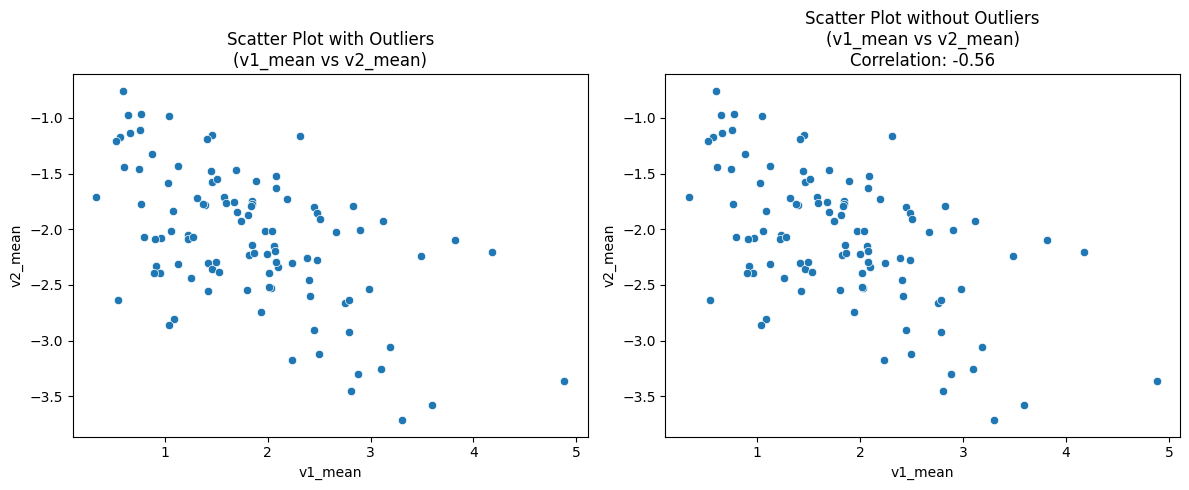

-0.5606353422335129

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

# Remove outliers for the first pair
data_no_outliers = data_subset[~outliers]

# Calculate correlation for the first pair without outliers
correlation = data_no_outliers.corr().iloc[0, 1]

# Plotting to show the process
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# Scatter plot with outliers
sns.scatterplot(data=data_subset, x=params[0], y=params[1], ax=ax[0])
ax[0].set_title(f'Scatter Plot with Outliers\n({params[0]} vs {params[1]})')

# Scatter plot without outliers
sns.scatterplot(data=data_no_outliers, x=params[0], y=params[1], ax=ax[1])
ax[1].set_title(f'Scatter Plot without Outliers\n({params[0]} vs {params[1]})\nCorrelation: {correlation:.2f}')

plt.tight_layout()
plt.show()

correlation


In [8]:
from itertools import combinations

# List of all selected parameters
selected_params = ['v1_mean', 'v2_mean', 'zr_mean', 'a_mean', 'ndt_mean', 'sndt_mean', 'alpha_mean', 
                   'alpha_mean_boxcox_after_arcsin', 'mean_log_rt', 'accuracy_percentage_boxcox_after_arcsin']

# Preparing a DataFrame to store correlations
correlation_matrix = pd.DataFrame(index=selected_params, columns=selected_params)

# Calculate Mahalanobis distance and correlations for each pair of parameters
for pair in combinations(selected_params, 2):
    pair_data = data[list(pair)]
    mahal_distances = safe_mahalanobis(x=pair_data, data=pair_data)
    outliers = mahal_distances > threshold
    correlation = pair_data[~outliers].corr().iloc[0, 1]
    correlation_matrix.loc[pair[0], pair[1]] = correlation
    correlation_matrix.loc[pair[1], pair[0]] = correlation  # Mirror the matrix

# Fill diagonal with NaN as we will put histograms there
np.fill_diagonal(correlation_matrix.values, np.nan)

correlation_matrix.head()  # Displaying the first few rows for review


/home/m.ebrahimi/.conda/envs/m_base/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
/home/m.ebrahimi/.conda/envs/m_base/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
/home/m.ebrahimi/.conda/envs/m_base/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axi

,v1_mean,v2_mean,zr_mean,a_mean,ndt_mean,sndt_mean,alpha_mean,alpha_mean_boxcox_after_arcsin,mean_log_rt,accuracy_percentage_boxcox_after_arcsin
v1_mean,NaN,-0.560635,-0.091742,0.456373,-0.28915,-0.454303,-0.241022,-0.255593,-0.227507,0.860943
v2_mean,-0.560635,NaN,-0.222655,-0.166066,0.392822,0.308279,0.104882,0.100116,0.539365,-0.654295
zr_mean,-0.091742,-0.222655,NaN,0.080813,-0.06266,-0.203031,-0.167933,-0.160417,0.031151,0.119109
a_mean,0.456373,-0.166066,0.080813,NaN,-0.236615,-0.429166,0.237425,0.287646,0.620751,0.718629
ndt_mean,-0.28915,0.392822,-0.06266,-0.236615,NaN,0.549028,-0.027873,0.015721,0.501115,-0.451058


/home/m.ebrahimi/.conda/envs/m_base/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
/home/m.ebrahimi/.conda/envs/m_base/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
/home/m.ebrahimi/.conda/envs/m_base/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axi

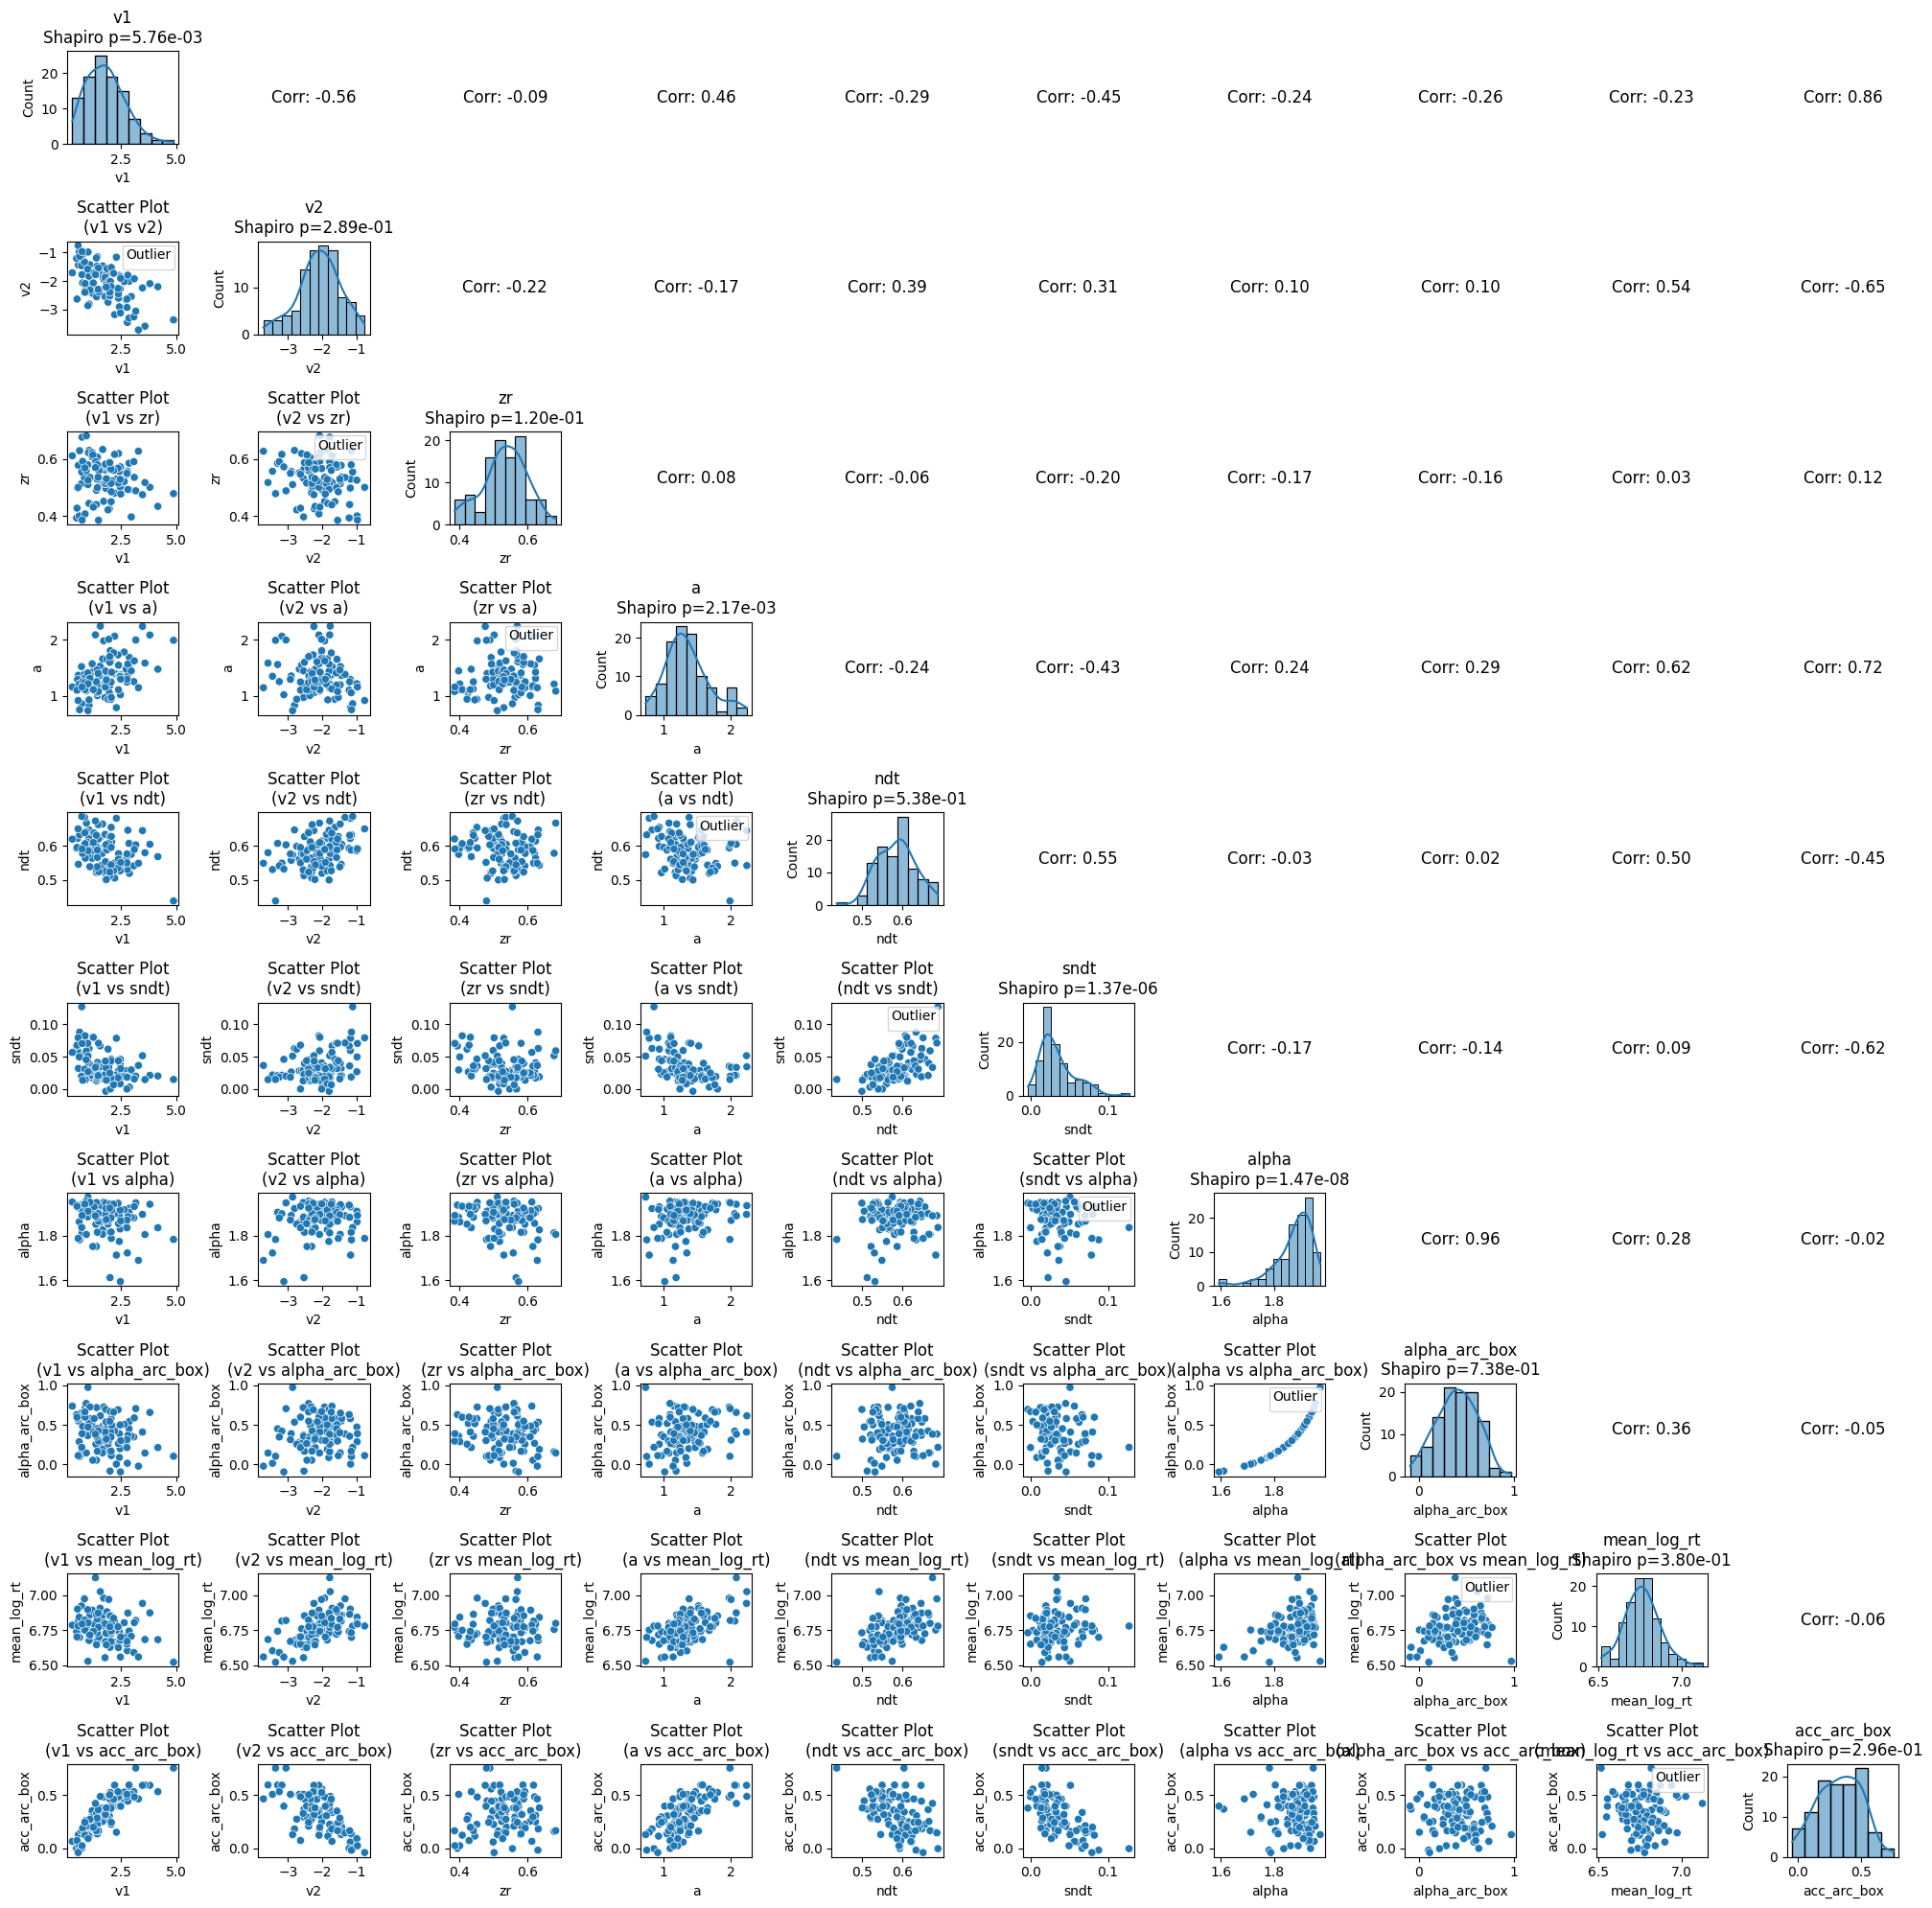

In [9]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
from itertools import combinations

# Function to calculate Mahalanobis distance
def safe_mahalanobis(x=None, data=None, cov=None):
    x_minus_mu = x - np.mean(data)
    if not cov:
        cov = np.cov(data.values.T)
    inv_covmat = np.linalg.inv(cov)
    left_term = np.dot(x_minus_mu, inv_covmat)
    mahal = np.dot(left_term, x_minus_mu.T)
    return mahal.diagonal()

# Load your data
data = pd.read_csv('rmt_session_1_data_transformed.csv')  # Replace with your file path

# Define your parameters
selected_params = ['v1_mean', 'v2_mean', 'zr_mean', 'a_mean', 'ndt_mean', 'sndt_mean', 
                   'alpha_mean', 'alpha_mean_boxcox_after_arcsin', 
                   'mean_log_rt', 'accuracy_percentage_boxcox_after_arcsin']

# Renaming for simplicity
renamed_params = {
    'v1_mean': 'v1', 'v2_mean': 'v2', 'zr_mean': 'zr', 'a_mean': 'a', 
    'ndt_mean': 'ndt', 'sndt_mean': 'sndt', 'alpha_mean': 'alpha', 
    'alpha_mean_boxcox_after_arcsin': 'alpha_arc_box', 
    'mean_log_rt': 'mean_log_rt', 
    'accuracy_percentage_boxcox_after_arcsin': 'acc_arc_box'
}
data_renamed = data.rename(columns=renamed_params)

# Prepare for outlier detection and correlation
correlation_matrix = pd.DataFrame(index=selected_params, columns=selected_params)
p_value = 0.001

# Process each pair of parameters
for pair in combinations(selected_params, 2):
    pair_data = data[list(pair)]
    mahal_distances = safe_mahalanobis(x=pair_data, data=pair_data)
    threshold = stats.chi2.ppf((1 - p_value), df=2)
    outliers = mahal_distances > threshold
    correlation = pair_data[~outliers].corr().iloc[0, 1]
    correlation_matrix.loc[pair[0], pair[1]] = correlation
    correlation_matrix.loc[pair[1], pair[0]] = correlation

np.fill_diagonal(correlation_matrix.values, np.nan)
correlation_matrix_renamed = correlation_matrix.rename(columns=renamed_params, index=renamed_params)

# Shapiro-Wilk test
shapiro_results = {}
for param in selected_params:
    shapiro_test = stats.shapiro(data[param])
    shapiro_results[param] = shapiro_test[1]
shapiro_results_renamed = {renamed_params[key]: value for key, value in shapiro_results.items()}

# Create the visualization
plt.figure(figsize=(20, 20))
for i, param_i in enumerate(renamed_params.values()):
    for j, param_j in enumerate(renamed_params.values()):
        plt.subplot(len(renamed_params), len(renamed_params), i*len(renamed_params) + j + 1)
        if i == j:
            sns.histplot(data_renamed[param_i], kde=True)
            plt.title(f'{param_i}\nShapiro p={shapiro_results_renamed[param_i]:.2e}')
        elif i > j:
            scatter_plot = sns.scatterplot(data=data_renamed, x=param_j, y=param_i, hue=outliers, legend=False)
            if i == j + 1:
                scatter_plot.legend(loc='upper right', title='Outlier', prop={'size': 6})
            plt.title(f'Scatter Plot\n({param_j} vs {param_i})')
        else:
            plt.text(0.5, 0.5, f'Corr: {correlation_matrix_renamed.iloc[i, j]:.2f}', 
                     horizontalalignment='center', verticalalignment='center', fontsize=12)
            plt.axis('off')

plt.tight_layout()
plt.savefig('RMT_S1_correlation_matrix_plot.png')  # Saves the plot to a file
plt.show()
plt.close()



In [10]:
correlation_matrix_renamed.to_csv('RMT_s1_correlation_matrix_renamed.csv')

In [ ]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
from itertools import combinations

# Function to calculate Mahalanobis distance
def safe_mahalanobis(x=None, data=None, cov=None):
    x_minus_mu = x - np.mean(data)
    if not cov:
        cov = np.cov(data.values.T)
    inv_covmat = np.linalg.inv(cov)
    left_term = np.dot(x_minus_mu, inv_covmat)
    mahal = np.dot(left_term, x_minus_mu.T)
    return mahal.diagonal()

# Load your data
data = pd.read_csv('rmt_session_1_data_transformed.csv')  # Replace with your file path

# Define your parameters
selected_params = ['v1_mean', 'v2_mean', 'zr_mean', 'a_mean', 'ndt_mean',
                  # 'sndt_mean', 'alpha_mean',
                   'alpha_mean_boxcox_after_arcsin', 
                   'mean_log_rt', 'accuracy_percentage_boxcox_after_arcsin']

# Renaming for simplicity
renamed_params = {
    'v1_mean': 'v1', 'v2_mean': 'v2', 'zr_mean': 'zr', 'a_mean': 'a', 
    'ndt_mean': 'ndt', #'sndt_mean': 'sndt',# 'alpha_mean': 'alpha', 
    'alpha_mean_boxcox_after_arcsin': 'alpha_arc_box', 
    'mean_log_rt': 'mean_log_rt', 
    'accuracy_percentage_boxcox_after_arcsin': 'acc_arc_box'
}
data_renamed = data.rename(columns=renamed_params)

# Prepare for outlier detection and correlation
correlation_matrix = pd.DataFrame(index=selected_params, columns=selected_params)
p_value = 0.001

# Process each pair of parameters
for pair in combinations(selected_params, 2):
    pair_data = data[list(pair)]
    mahal_distances = safe_mahalanobis(x=pair_data, data=pair_data)
    threshold = stats.chi2.ppf((1 - p_value), df=2)
    outliers = mahal_distances > threshold
    correlation = pair_data[~outliers].corr().iloc[0, 1]
    correlation_matrix.loc[pair[0], pair[1]] = correlation
    correlation_matrix.loc[pair[1], pair[0]] = correlation

np.fill_diagonal(correlation_matrix.values, np.nan)
correlation_matrix_renamed = correlation_matrix.rename(columns=renamed_params, index=renamed_params)

# Shapiro-Wilk test
shapiro_results = {}
for param in selected_params:
    shapiro_test = stats.shapiro(data[param])
    shapiro_results[param] = shapiro_test[1]
shapiro_results_renamed = {renamed_params[key]: value for key, value in shapiro_results.items()}

# Create the visualization
plt.figure(figsize=(20, 20))
for i, param_i in enumerate(renamed_params.values()):
    for j, param_j in enumerate(renamed_params.values()):
        plt.subplot(len(renamed_params), len(renamed_params), i*len(renamed_params) + j + 1)
        if i == j:
            sns.histplot(data_renamed[param_i], kde=True)
            plt.title(f'{param_i}\nShapiro p={shapiro_results_renamed[param_i]:.2e}')
        elif i > j:
            scatter_plot = sns.scatterplot(data=data_renamed, x=param_j, y=param_i, hue=outliers, legend=False)
            if i == j + 1:
                scatter_plot.legend(loc='upper right', title='Outlier', prop={'size': 6})
            #plt.title(f'Scatter Plot\n({param_j} vs {param_i})')
        else:
            plt.text(0.5, 0.5, f'Corr: {correlation_matrix_renamed.iloc[i, j]:.2f}', 
                     horizontalalignment='center', verticalalignment='center', fontsize=12)
            plt.axis('off')

plt.tight_layout()
plt.show()

plt.savefig('RMT_s1_exclude_sndt_alphaMean_correlation_matrix_plot.png')  # Saves the plot to a file
plt.close()



/home/m.ebrahimi/.conda/envs/m_base/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
/home/m.ebrahimi/.conda/envs/m_base/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
/home/m.ebrahimi/.conda/envs/m_base/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axi

In [ ]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
from itertools import combinations

# Function to calculate Mahalanobis distance
def safe_mahalanobis(x=None, data=None, cov=None):
    x_minus_mu = x - np.mean(data)
    if not cov:
        cov = np.cov(data.values.T)
    inv_covmat = np.linalg.inv(cov)
    left_term = np.dot(x_minus_mu, inv_covmat)
    mahal = np.dot(left_term, x_minus_mu.T)
    return mahal.diagonal()

# Load your data
data = pd.read_csv('rmt_session_1_data_transformed.csv')  # Replace with your file path

# Define your parameters
selected_params = ['v1_mean', 'v2_mean', #'zr_mean',
                   'a_mean', 'ndt_mean',
                  # 'sndt_mean', 'alpha_mean',
                   'alpha_mean_boxcox_after_arcsin', 
                   'mean_log_rt', 'accuracy_percentage_boxcox_after_arcsin']

# Renaming for simplicity
renamed_params = {
    'v1_mean': 'v1', 'v2_mean': 'v2',# 'zr_mean': 'zr', 
    'a_mean': 'a', 
    'ndt_mean': 'ndt', #'sndt_mean': 'sndt',# 'alpha_mean': 'alpha', 
    'alpha_mean_boxcox_after_arcsin': 'alpha_arc_box', 
    'mean_log_rt': 'mean_log_rt', 
    'accuracy_percentage_boxcox_after_arcsin': 'acc_arc_box'
}
data_renamed = data.rename(columns=renamed_params)

# Prepare for outlier detection and correlation
correlation_matrix = pd.DataFrame(index=selected_params, columns=selected_params)
p_value = 0.001

# Process each pair of parameters
for pair in combinations(selected_params, 2):
    pair_data = data[list(pair)]
    mahal_distances = safe_mahalanobis(x=pair_data, data=pair_data)
    threshold = stats.chi2.ppf((1 - p_value), df=2)
    outliers = mahal_distances > threshold
    correlation = pair_data[~outliers].corr().iloc[0, 1]
    correlation_matrix.loc[pair[0], pair[1]] = correlation
    correlation_matrix.loc[pair[1], pair[0]] = correlation

np.fill_diagonal(correlation_matrix.values, np.nan)
correlation_matrix_renamed = correlation_matrix.rename(columns=renamed_params, index=renamed_params)

# Shapiro-Wilk test
shapiro_results = {}
for param in selected_params:
    shapiro_test = stats.shapiro(data[param])
    shapiro_results[param] = shapiro_test[1]
shapiro_results_renamed = {renamed_params[key]: value for key, value in shapiro_results.items()}

# Create the visualization
plt.figure(figsize=(20, 20))
for i, param_i in enumerate(renamed_params.values()):
    for j, param_j in enumerate(renamed_params.values()):
        plt.subplot(len(renamed_params), len(renamed_params), i*len(renamed_params) + j + 1)
        if i == j:
            sns.histplot(data_renamed[param_i], kde=True)
            plt.title(f'{param_i}\nShapiro p={shapiro_results_renamed[param_i]:.2e}')
        elif i > j:
            scatter_plot = sns.scatterplot(data=data_renamed, x=param_j, y=param_i, hue=outliers, legend=False)
            if i == j + 1:
                scatter_plot.legend(loc='upper right', title='Outlier', prop={'size': 6})
            #plt.title(f'Scatter Plot\n({param_j} vs {param_i})')
        else:
            plt.text(0.5, 0.5, f'Corr: {correlation_matrix_renamed.iloc[i, j]:.2f}', 
                     horizontalalignment='center', verticalalignment='center', fontsize=12)
            plt.axis('off')

plt.tight_layout()
plt.show()

plt.savefig('RMT_s1_exclude_sndt_alphaMean_zr_correlation_matrix_plot.png')  # Saves the plot to a file
plt.close()

